# Zadanie 3 TEXT MINING
Plik superheroes.xlsx zawiera dane dotyczące komiksowych superbohaterek i superbohaterów.
Zadanie polega na zbudowaniu klasyfikatora, który na podstawie historii danej postaci (pole
history_text) oraz opisu jej supermocy (pole powers_text) stwierdzi z jakiego wydawnictwa ona
pochodzi. Dokładniej mówiąc klasyfikator powinien przypisać postać do jednej z trzech klas: Marvel
Comics, DC Comics, inne wydawnictwo (informacja o wydawnictwie znajduje się w polu creator). 
1. Podziel dane na zbiór uczący i testowy (w proporcjach 70% - 30%). Zadbaj o odpowiednią
reprezentację wszystkich klas w obu zbiorach.
2. Przekształć dane do postaci nadającej się do analizy.
3. Zbuduj przynajmniej trzy klasyfikatory różnego typu. Dobierz optymalne wartości
parametrów tych klasyfikatorów oraz optymalną reprezentację danych tekstowych.
4. Sprawdź jakość zbudowanych klasyfikatorów na zbiorze testowym, stosując odpowiednie
miary jakości. Porównaj wyniki uzyskane przez te klasyfikatory.
5. Na podstawie zbioru uczącego utwórz listy 30 słów, które mają największy wpływ na
zaklasyfikowanie postaci do danego wydawnictwa (niektóre klasyfikatory pozwalają na
wydobycie takich danych, można też dokonać analizy porównawczej częstości występowania
wyrazów w poszczególnych klasach).
6. Sprawdź, jak wpłynie na jakość klasyfikacji uwzględnienie innych cech postaci (tzn. tych
niepochodzących z pól history_text i powers_text). 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

from yellowbrick.classifier import ROCAUC


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 1. Klasyfikacja dla dwóch zmiennych *history_text* oraz *powers_text*





## 1. Wczytanie zbioru danych oraz import potrzebnych bibliotek

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 20)

In [5]:
dane = pd.read_csv('superheroes.csv')
dane.head()

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hil...,NaN,100,20,30,50,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,100,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,40,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tabela z danymi posiada 1450 rekordów i 81 zmiennych, zarówno tekstowych jak i liczbowych.

In [6]:
dane.shape

(1450, 81)

In [7]:
print("Nazwy kolumn:")
print(dane.columns)

Nazwy kolumn:
Index(['name', 'real_name', 'full_name', 'overall_score', 'history_text',
       'powers_text', 'intelligence_score', 'strength_score', 'speed_score',
       'durability_score', 'power_score', 'combat_score', 'superpowers',
       'alter_egos', 'aliases', 'place_of_birth', 'first_appearance',
       'creator', 'alignment', 'occupation', 'base', 'teams', 'relatives',
       'gender', 'type_race', 'height', 'weight', 'eye_color', 'hair_color',
       'skin_color', 'img', 'has_electrokinesis', 'has_energy_constructs',
       'has_mind_control_resistance', 'has_matter_manipulation',
       'has_telepathy_resistance', 'has_mind_control', 'has_enhanced_hearing',
       'has_dimensional_travel', 'has_element_control', 'has_size_changing',
       'has_fire_resistance', 'has_fire_control', 'has_dexterity',
       'has_reality_warping', 'has_illusions', 'has_energy_beams',
       'has_peak_human_condition', 'has_shapeshifting', 'has_heat_resistance',
       'has_jump', 'has_self-su

Przekształcenie zmiennej celu *creator*, aby skategoryzować ją na 3 następujące kategorie Marvel Comics, DC Comics lub inne wydawnictwo. 

In [8]:
dane['creator'].value_counts()

Marvel Comics             615
DC Comics                 444
Shueisha                   37
Dark Horse Comics          29
Lego                       22
                         ... 
Stephen King                1
Konami                      1
Blizzard Entertainment      1
South Park                  1
Matt Groening               1
Name: creator, Length: 41, dtype: int64

Rekodujemy zmienną celu, aby miała odpowiedenie kategorie.

In [9]:
wydawnictwo = [x if x=='Marvel Comics' else (x if x=='DC Comics' else'Inne wydawnictwo') for x in dane['creator']]

In [10]:
dane['wydawnictwo'] = wydawnictwo
dane['wydawnictwo'].value_counts()

Marvel Comics       615
DC Comics           444
Inne wydawnictwo    391
Name: wydawnictwo, dtype: int64

Musimy napisać funckję, która łączy dwie kolumny tesktowe w jedną, w tym wypadku *history_text* oraz *power_text*.

In [11]:
def marge_cols(df, col1, col2, col3='wydawnictwo'):
  result = []
  y = []
  for i in range(len(df)):
    if str(df[col1][i])!='nan' and str(df[col2][i])!='nan':
      result.append(str(df[col1][i])+' '+str(df[col2][i]))
      y.append(str(df[col3][i]))
  return pd.DataFrame(result, columns=['text_to_classification']), pd.Series(y)

Tworzymy nasz zbiór danych *X* oraz *y*.

In [12]:
X,y=marge_cols(dane,'history_text', 'powers_text', 'wydawnictwo')

Podzielimy dane na zbiór uczący i testowy (w proporcjach 70% - 30%). O odpowiednią reprezentację wszystkich klas w obu zbiorach zadbamy poprzez wykorzystanie parametru *stratify=y*, tzn. zbiory uczący i testowy będą miały strukturę *y*.

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=0,
                                                    stratify=y)

Sprawdźmy czy rzeczywiście dane odpowiednio się podzieliły.

In [14]:
y.value_counts()

Marvel Comics       475
DC Comics           285
Inne wydawnictwo    236
dtype: int64

In [15]:
y_train.value_counts()

Marvel Comics       332
DC Comics           200
Inne wydawnictwo    165
dtype: int64

In [16]:
y_test.value_counts()

Marvel Comics       143
DC Comics            85
Inne wydawnictwo     71
dtype: int64

In [17]:
y_train.to_csv('y_train.csv', sep=';')
y_test.to_csv('y_test.csv', sep = ';')

Widzimy, że dane zostały rozdzielone w odpowiednich proporcjach.

## 2. Strukturyzacja danych

Dane zostaną przekształcone do postaci macierzy tf-idf. Przed przekształcaniem teksty zostaną zamienione na małe litery, stworzymy z tekstów listy tokenów, usuniemy z nich numery i znaki interpunkcyjne. Tokeny zostaną zlematyzowane, usunięte zostaną angielskie stop-words. Dodatkowo zostały usunięte słowa, które zawierały inne znaki niż ascii.

In [18]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def to_lower(text):
 
        return text.lower() 

def remove_numbers(text):
   
        output = ''.join(c for c in text if not c.isdigit())
        return output 

def remove_punct(text):
        punctuation_marks = [',', '.', '?', '!', '#', '*', ':', ';', '”', '“', "’", "’"]
        return ''.join(c for c in text if c not in punctuation_marks) 

def lemmatize(text):
    
        wordnet_lemmatizer = WordNetLemmatizer()

        lemmatized_word = [wordnet_lemmatizer.lemmatize(word)for word in nltk.word_tokenize(text)]
        return " ".join(lemmatized_word) 

def word_tokenize(text):
    
        return nltk.word_tokenize(text)

In [20]:
def preprocess(text):
        stop_words = stopwords.words('english')
        lower_text = to_lower(text)
        word_tokens = word_tokenize(lower_text)
        word_list = []
        for each_sent in word_tokens:
            lemmatizzed_sent = lemmatize(each_sent)
            clean_text = remove_numbers(lemmatizzed_sent)
            clean_text = remove_punct(clean_text)
            if clean_text not in stop_words and  len(clean_text)>2 and clean_text.isascii():
                 word_list.append(clean_text)
        return word_list

In [21]:
X_train = x_train.text_to_classification.apply(preprocess)

In [22]:
X_train

834    [melissa, gold, child, mother, sent, prison, r...
277    [early, doctor, charles, mcnider, nurse/assist...
15     [melinda, may, born, william, intelligence, op...
927    [little, known, childhood, suzy, sherman, apar...
177    [george, digger, harkness, raised, poverty, au...
                             ...                        
723    [man, used, test, subject, norman, osborn, yea...
671    [born, daniel, dreiberg, relied, upon, technic...
464    [doctor, jane, foster, one, world, leading, as...
833    [solomon, kane, raised, puritan, heresy, activ...
93     [bruce, wayne, son, wealthy, socialite, thomas...
Name: text_to_classification, Length: 697, dtype: object

In [23]:
X_test = x_test.text_to_classification.apply(preprocess)

In [24]:
X_test

849    [carol, ferris, bos, occasional, love, interes...
471    [jesse, chamber, daughter, golden, age, johnny...
11     [bob, agent, hydra, sidekick, deadpool, coward...
195    [early, year, like, elder, universe, champion,...
644    [jamie, madrox, mutant, ability, apparent, bir...
                             ...                        
30     [originally, built, power, skill, original, ju...
398    [described, genius-level, harleen, attended, g...
597    [medusalith, medusa, amaquelin, wife, black, b...
494    [universe, selecting, team, kale, one, foe, an...
336    [ronnie, raymond, engaged, caitlin, snow, nigh...
Name: text_to_classification, Length: 299, dtype: object

Przygotowany tekst, który aktualnie jest listą słow dla każdego rekordu, zostanie zamieniony na macierz tf-idf.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer()

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.astype(str))
X_test_tfidf = vectorizer_tfidf.transform(X_test.astype(str))

Po takim przygotowaniu macierz dla zbioru uczącego ma 697 wierszy i 22877 kolumn, a macierz dla zbioru testowego ma odpowiednio mniej, bo 299 wieszy i tyle samo kolumn. 

In [26]:
X_train_tfidf.shape, X_test_tfidf.shape

((697, 22755), (299, 22755))

In [27]:
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

 22755 to całkowita długość słownika korpusu uczącego. Oznacza to, że w korpusie uczącym znajduje się 22755 unikalnych słów/ciągów znaków.

In [28]:
len(vectorizer_tfidf.vocabulary_)

22755

In [ ]:
vectorizer_tfidf.vocabulary_

In [76]:
y_train.value_counts()

Marvel Comics       332
DC Comics           200
Inne wydawnictwo    165
dtype: int64

In [31]:
X_train = pd.DataFrame(X_train_tfidf).set_index(y_train)

Aby ułatwić zapisałam powstałe macierze, ponieważ sam preprocessing zabiera sporo czasu. Macierze te dostępne są w załącznikach.

In [36]:
pd.DataFrame(X_train_tfidf).to_csv("X_train_tfidf.csv", sep=';')
pd.DataFrame(X_test_tfidf).to_csv("X_test_tfidf.csv", sep=';')

## 3. Naiwny klasyfikator Bayesa

Pierwszym sprawdzonym modelem będzie naiwny klasyfikator Bayesa. Modelu możemy używać wprost, nie ma potrzeby tuningowania parametrów.

In [37]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_tfidf, y_train)

GaussianNB()

In [38]:
gnb_clf.score(X_train_tfidf, y_train), gnb_clf.score(X_test_tfidf, y_test)

(1.0, 0.8795986622073578)

In [39]:
from sklearn.metrics import classification_report
y_pred_gnb_test= gnb_clf.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_gnb_test)) 

                  precision    recall  f1-score   support

       DC Comics       0.88      0.93      0.90        85
Inne wydawnictwo       0.90      0.65      0.75        71
   Marvel Comics       0.87      0.97      0.92       143

        accuracy                           0.88       299
       macro avg       0.88      0.85      0.86       299
    weighted avg       0.88      0.88      0.87       299



Trafność zarówno na zbiorze uczącym jak i testowym jest bardzo dobra, na zbiorze uczącym nie było ani jednej pomyłki. Na zbiorze testowym jest ona na poziomie 88%. Po miarze $F1-score$ liczonej dla każdej z grup zbioru testowego obserwujemy, że dla jedynie dla grupy *Inne wydawnictwo* model poradził sobie nieco gorzej przy predykcji dla zbioru testowego, Można próbować uzasadnić to tym, że grupa ta zawiera wiele bardzo różnych wydawnictw, i te różnice mogą zaburzać predykcyjność modelu.  

### Naiwny klasyfikator Bayesa - wielomianowy

In [67]:
from sklearn.naive_bayes import MultinomialNB
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [68]:
mnb_clf.score(X_train_tfidf, y_train), mnb_clf.score(X_test_tfidf, y_test)

(0.793400286944046, 0.6086956521739131)

In [69]:
y_pred_mnb_test= mnb_clf.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_mnb_test)) 

                  precision    recall  f1-score   support

       DC Comics       0.97      0.33      0.49        85
Inne wydawnictwo       0.92      0.17      0.29        71
   Marvel Comics       0.55      0.99      0.71       143

        accuracy                           0.61       299
       macro avg       0.81      0.50      0.50       299
    weighted avg       0.76      0.61      0.55       299



MultinomialNB pozwala na wyciągnięcie słów, które mają największy wpływ na zaklasyfikowanie postaci do danego wydawnictwa. Dlatego też został użyty tyklo w tym celu. Nie będziemy rysować dla niego krzywych ROC, ponieważ, wyniki tego modelu nie są rewelacyjne, już na zbiorze uczącym trafność jest niższa niż 80%, a na testowym 61%. Bardzo słabo poradził sobie z klasyfikacją dla kategorii *Inne wydawnictwo*, $f-1=0.29$. Dla kategorii *Marvel* poradził sobie całkiem nieźle, ale zobaczymy później, że inne modele poradziły sobie znacznie lepiej.

In [70]:
mnb_clf.classes_

array(['DC Comics', 'Inne wydawnictwo', 'Marvel Comics'], dtype='<U16')

In [72]:
importances = pd.DataFrame()
importances['Marvel Comics']=mnb_clf.feature_count_[2] 
importances['DC Comics']=mnb_clf.feature_count_[0]
importances['Inne wydawnictwo']=mnb_clf.feature_count_[1]

In [73]:
importances

,Marvel Comics,DC Comics,Inne wydawnictwo
0,0.000000,0.044045,0.0
1,0.000000,0.022400,0.0
2,0.021974,0.000000,0.0
3,0.017803,0.000000,0.0
4,0.017803,0.000000,0.0
...,...,...,...
22750,0.000000,0.011434,0.0
22751,0.000000,0.008827,0.0
22752,0.000000,0.003728,0.0
22753,0.000000,0.009622,0.0


In [75]:
DC = importances.sort_values(by=['DC Comics'],ascending=False)['DC Comics'][0:30].index
Marvel = importances.sort_values(by=['Marvel Comics'],ascending=False)['Marvel Comics'][0:30].index
Inne = importances.sort_values(by=['Inne wydawnictwo'],ascending=False)['Inne wydawnictwo'][0:30].index

In [77]:
DC_words = [vectorizer_tfidf.get_feature_names()[i] for i in DC]
Marvel_words = [vectorizer_tfidf.get_feature_names()[i] for i in Marvel]
Inne_words = [vectorizer_tfidf.get_feature_names()[i] for i in Inne]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
print(f"Największy wpływ na zaklasyfikowanie postaci do wydawnictwa 'Marvel Comics' mają słowa: {Marvel_words},\n do wydawnictwa DC Comics: {DC_words},\n oraz do innego wydawnictwa {Inne_words}", )

Największy wpływ na zaklasyfikowanie postaci do wydawnictwa 'Marvel Comics' mają słowa: ['mutant', 'power', 'man', 'spider', 'men', 'able', 'new', 'time', 'avenger', 'one', 'team', 'also', 'hulk', 'ability', 'human', 'body', 'earth', 'energy', 'force', 'later', 'xavier', 'however', 'black', 'could', 'thor', 'would', 'shield', 'wolverine', 'superhuman', 'even'],
 do wydawnictwa DC Comics: ['batman', 'superman', 'power', 'flash', 'able', 'earth', 'time', 'wayne', 'speed', 'one', 'also', 'bruce', 'gotham', 'city', 'father', 'ability', 'black', 'robin', 'adam', 'would', 'oliver', 'body', 'force', 'later', 'even', 'arrow', 'justice', 'life', 'barry', 'ray'],
 oraz do innego wydawnictwa ['ninja', 'garmadon', 'lloyd', 'power', 'master', 'ninjago', 'also', 'ability', 'serpentine', 'overlord', 'time', 'able', 'assassin', 'dragon', 'zane', 'spinjitzu', 'one', 'would', 'elemental', 'even', 'first', 'like', 'weapon', 'chen', 'kai', 'could', 'war', 'realm', 'human', 'brother']


## 4. Knn

Następnym klasyfikatorem jest $k$-najbliższych sąsiadów. Tutaj należy z góry ustalić ilość sąsiadów, tutaj $k=3$ ze względu, iż wiemy jakie wartości przyjmuje zmienna celu i że dzieli się na 3 kategorie. 

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_tfidf, y_train)

KNeighborsClassifier(n_neighbors=3)

In [50]:
knn_clf.score(X_train_tfidf, y_train), knn_clf.score(X_test_tfidf, y_test)

(0.9325681492109039, 0.8595317725752508)

In [51]:
y_pred_knn_test= knn_clf.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_knn_test)) 

                  precision    recall  f1-score   support

       DC Comics       0.78      0.89      0.83        85
Inne wydawnictwo       0.90      0.63      0.74        71
   Marvel Comics       0.90      0.95      0.93       143

        accuracy                           0.86       299
       macro avg       0.86      0.83      0.83       299
    weighted avg       0.86      0.86      0.86       299



W tym przypadku model na zbiorze uczącym poradził sobie nieco gorzej, testowy podobnie do poprzednika. Obserwujemy, że najmniejszy problem jest z przypisaniem do klasy *Marvel Comics* $f1=0.93$, natomiast jak wcześniej największy problem jest z przypisaniem do kategorii *Inne wydawnictwo* $f1=0.74$.

##5. Drzewo

W modelu drzewa mamy sporo parametrów do ustawienia, sprawdzimy je poprzez 3 krotną kroswalidację, aby dostać najlepsze parametry dla naszego zbioru.

In [40]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [41]:
tree_clf.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Liczba cech do rozważenia przy każdym podziale
max_features = ['auto', 'sqrt']
# Maksymalna liczba poziomów w drzewie
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimalna liczba próbek wymagana do podziału 
min_samples_split = [2, 5, 10]
# Minimalna liczba próbek wymagana w każdym węźle liścia
min_samples_leaf = [1, 2, 4]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [43]:
grid_search_tree = GridSearchCV(estimator = tree_clf, param_grid = random_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [44]:
grid_search_tree.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [45]:
grid_search_tree.best_params_

{'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10}

Najlepsze parametry:


{'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10}. 
 
 Sprawdźmy jak wyglądają miary jakości dla tego zestawu parametrów.

In [58]:
tree_clf_best = tree.DecisionTreeClassifier(max_depth=60, max_features ='auto', min_samples_leaf=4, min_samples_split=10)
tree_clf_best.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=60, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10)

In [59]:
tree_clf_best.score(X_train_tfidf, y_train), tree_clf_best.score(X_test_tfidf, y_test)

(0.7747489239598279, 0.6187290969899666)

In [60]:
y_pred_tree_test= tree_clf_best.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_tree_test))

                  precision    recall  f1-score   support

       DC Comics       0.58      0.55      0.57        85
Inne wydawnictwo       0.48      0.52      0.50        71
   Marvel Comics       0.72      0.71      0.71       143

        accuracy                           0.62       299
       macro avg       0.59      0.59      0.59       299
    weighted avg       0.62      0.62      0.62       299



Mimo doboru parametrów, widzimy, że model drzewa nie radzi sobie z predykcją na zbiorze testowym. Trafnośc na poziomie 62% jest jedynie zadowalająca. Szczególnie, że wcześniejsze modele poradziły sobie znacznie lepiej. O dziwo patrząc na miarę $f1$ najbardziej problematyczną kategorią dla tego modelu było *DC Comics*, *Inne wydawnictwo* nieznacznie lepiej i "najlepiej" poradził sobie z przypisaniem do *Marvel Comics* (chociaż ciężko tu mówić o najlepszym dopasowaniu gdy miara $f1$ wynosi dla tej kategorii 0.71).

## 6. SVM

Dla SVM również posłużymy się kroswalidacją w celu zbudowania modelu dla najlepszych parametrów. Najlepszy model definiujemy jako taki, który ma najlepszą trafność (to również jest parametr którym możemy manipulować).

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

In [53]:
tuned_parameters = [
    {"kernel": ["rbf"],'gamma': ['auto', 'scale'], "C": [0.0001,0.001,0.01,0.1,1, 10]},
    {"kernel": ["linear"],  "C": [0.0001,0.001,0.01,0.1,1, 10]},
    {"kernel":["poly"], 'degree': list(range(2,5)), 'gamma': ['auto', 'scale']}
]

score="accuracy"
print("# Strojenie hiperparametrów dla największej trafności, ang. %s" % score)
print()
clf = GridSearchCV(SVC(), tuned_parameters, scoring=score)

clf.fit(X_train_tfidf, y_train)

print("Najlepszy zestaw parametrów:")
print()
print(clf.best_params_)
print()
print("Wyniki dla kolejnych zestawów parametrów:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) dla %r" % (mean, std * 2, params))
print()

# Strojenie hiperparametrów dla największej trafności, ang. accuracy

Najlepszy zestaw parametrów:

{'C': 1, 'kernel': 'linear'}

Wyniki dla kolejnych zestawów parametrów:

0.476 (+/-0.004) dla {'C': 0.0001, 'gamma': 'auto', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.0001, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.743 (+/-0.047) dla {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.803 (+/-0.066) dla {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.476 (+/-0.004) dla {'

Najlepszy wynik kroswalidacji uzyskaliśmy dla jądra liniowego i parametru C=1, dla niego trafność to 0.875. Nieznacznie gorszy wynik uzyskaliśmy dla jądra liniowego i C=10, trafność wynosi 0.869. Trzeci w koleności wynik jest dla jądra "radial" z parametrami C=10 oraz gamma = scale.

In [54]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=1)

In [55]:
svm_clf.fit(X_train_tfidf, y_train)

LinearSVC(C=1)

In [56]:
svm_clf.score(X_train_tfidf, y_train), svm_clf.score(X_test_tfidf, y_test)

(0.9985652797704447, 0.8762541806020067)

In [57]:
y_pred_svm_test= svm_clf.predict(X_test_tfidf)
print(classification_report(y_test,y_pred_svm_test))

                  precision    recall  f1-score   support

       DC Comics       0.87      0.88      0.88        85
Inne wydawnictwo       0.89      0.66      0.76        71
   Marvel Comics       0.88      0.98      0.92       143

        accuracy                           0.88       299
       macro avg       0.88      0.84      0.85       299
    weighted avg       0.88      0.88      0.87       299



Model ten poradził sobie najlepiej ze zbiorem testowym. Trafnośc na tym zbiorze wynosi 88%. Jak wcześniej najgorzej przewidywaną grupą jest *Inne wydawnictwo*, ale $f-1=0.76$ nie jest wynikiem tragicznym. Szczególnie, że dla dwóch innych kategorii miara $f-1$ jest bardzo wysoka. 

## 7. ROC


Dobrym sprawdzeniem są również krzywe ROC, sprawdźmy jak one będą wyglądać.

Musimy najpierw przemapować kategorie. Oraz napisać odpowiednią funkcję, korzystając z pakietu, który i tak dużo ułatwia *yellowbrick*.

In [61]:
y_train_t = y_train.map({'DC Comics':0, 'Marvel Comics':1, 'Inne wydawnictwo':2})
y_test_t = y_test.map({'DC Comics':0, 'Marvel Comics':1, 'Inne wydawnictwo':2})

In [62]:
from yellowbrick.classifier import ROCAUC


def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Tworzenie wizualizacji z czytelnymi etykietami
    visualizer = ROCAUC(model, classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],micro=False, macro=False, force_model=True)
                                        
    # Najpierw dopasowanie do danych treningowych, a następnie punktacja za pomocą danych testowych                                   
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


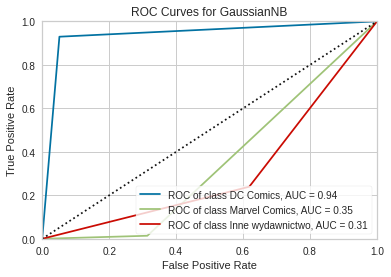

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f92407de7d0>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=GaussianNB(), force_model=True, macro=False, micro=False)

In [63]:
plot_ROC_curve(gnb_clf, X_train_tfidf, y_train_t, X_test_tfidf, y_test_t)

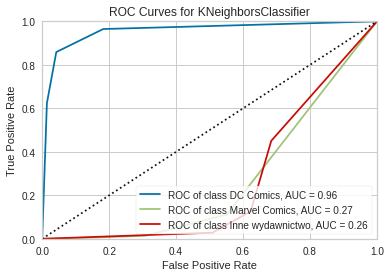

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f924078bdd0>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=KNeighborsClassifier(n_neighbors=3), force_model=True,
       macro=False, micro=False)

In [64]:
plot_ROC_curve(knn_clf, X_train_tfidf, y_train_t, X_test_tfidf, y_test_t)

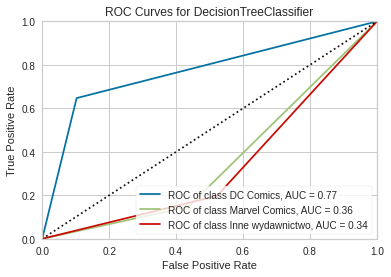

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f924074ee10>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=DecisionTreeClassifier(), force_model=True, macro=False,
       micro=False)

In [65]:
plot_ROC_curve(tree_clf, X_train_tfidf, y_train_t, X_test_tfidf, y_test_t)

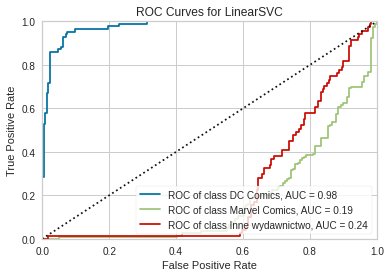

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f92407f6250>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=LinearSVC(C=1), force_model=True, macro=False, micro=False)

In [66]:
plot_ROC_curve(svm_clf, X_train_tfidf, y_train_t, X_test_tfidf, y_test_t)

Krzywe ROC zostały narysowane metodą jeden przeciwko wszystkim, tzn. gdy rysujemy krzywą dla kategorii *Marvel* uznajemy to jako 1, a *DC* oraz *Inne wydawnictwo* uznajemy jako 0, zamieniając to na problem binarny.

## 8. Wnioski

Uważam, że narysowanie krzywych ROC miało jak najbardziej sens. Wcześniej zastanawiałam się nad wybraniem najlepszego modelu między modelem SVM z wybranymi parametrami i modelem Naiwnego Bayesa. Miary jakości dla obydwu tych modeli były bardzo zbliżone. Myślałam, że uśrednione miary $f-1$ pozwolą na wyciągnięcie większych wniosków, ale tak też się nie stało.  Mimo "kanciastej" linii dla NB, miary AUC dla 2 klas słabiej rozpoznawalnych przez modele są powyżej 0.3. A dla modelu SVM poniżej 0.25. A więc dopiero z krzywych ROC uznaję, że najlepszym wyborem dla tego zbioru danych i spośród zbadanych modeli jest model Naiwnego Bayesa.

# 2. Klasyfikacja dla większej ilości zmiennych


## 1. Przygotowanie danych

In [83]:
dane_dod = dane.fillna(0).replace(['∞', '-'],0)

In [84]:
dane_dod.columns

Index(['name', 'real_name', 'full_name', 'overall_score', 'history_text',
       'powers_text', 'intelligence_score', 'strength_score', 'speed_score',
       'durability_score', 'power_score', 'combat_score', 'superpowers',
       'alter_egos', 'aliases', 'place_of_birth', 'first_appearance',
       'creator', 'alignment', 'occupation', 'base', 'teams', 'relatives',
       'gender', 'type_race', 'height', 'weight', 'eye_color', 'hair_color',
       'skin_color', 'img', 'has_electrokinesis', 'has_energy_constructs',
       'has_mind_control_resistance', 'has_matter_manipulation',
       'has_telepathy_resistance', 'has_mind_control', 'has_enhanced_hearing',
       'has_dimensional_travel', 'has_element_control', 'has_size_changing',
       'has_fire_resistance', 'has_fire_control', 'has_dexterity',
       'has_reality_warping', 'has_illusions', 'has_energy_beams',
       'has_peak_human_condition', 'has_shapeshifting', 'has_heat_resistance',
       'has_jump', 'has_self-sustenance', 'ha

In [85]:
num_cols = ['overall_score', 'intelligence_score', 'strength_score', 'speed_score',
       'durability_score', 'power_score', 'combat_score', 'has_electrokinesis', 'has_energy_constructs',
       'has_mind_control_resistance', 'has_matter_manipulation',
       'has_telepathy_resistance', 'has_mind_control', 'has_enhanced_hearing',
       'has_dimensional_travel', 'has_element_control', 'has_size_changing',
       'has_fire_resistance', 'has_fire_control', 'has_dexterity',
       'has_reality_warping', 'has_illusions', 'has_energy_beams',
       'has_peak_human_condition', 'has_shapeshifting', 'has_heat_resistance',
       'has_jump', 'has_self-sustenance', 'has_energy_absorption',
       'has_cold_resistance', 'has_magic', 'has_telekinesis',
       'has_toxin_and_disease_resistance', 'has_telepathy', 'has_regeneration',
       'has_immortality', 'has_teleportation', 'has_force_fields',
       'has_energy_manipulation', 'has_endurance', 'has_longevity',
       'has_weapon-based_powers', 'has_energy_blasts', 'has_enhanced_senses',
       'has_invulnerability', 'has_stealth', 'has_marksmanship', 'has_flight',
       'has_accelerated_healing', 'has_weapons_master', 'has_intelligence',
       'has_reflexes', 'has_super_speed', 'has_durability', 'has_stamina',
       'has_agility', 'has_super_strength',]
text_cols = ['history_text',
       'powers_text', 'superpowers',
       'alter_egos', 'aliases', 'place_of_birth', 'first_appearance',
       'alignment', 'occupation', 'base', 'teams', 'relatives',
       'gender', 'type_race', 'height', 'weight', 'eye_color', 'hair_color',
       'skin_color']

## 2. Przygotowanie danych numerycznych, standaryzacja

In [86]:
df_num = dane_dod[num_cols].astype(float)

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num_standarized = pd.DataFrame(scaler.fit_transform(df_num))

In [88]:
df_num_standarized

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.340330,0.235488,-0.27517,0.466174,0.120331,-0.810323,0.061772,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,1.307777,-0.97682,-1.016691,-1.075982,0.991758
1,-0.153971,0.834535,-0.56609,-0.561370,-0.195756,-0.960863,1.077680,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,1.202162,-0.764656,1.02373,-1.016691,-1.075982,0.991758
2,0.311927,0.035805,1.76127,1.151204,1.384682,0.996162,0.400408,-0.307148,-0.280836,-0.279405,...,-0.584252,1.550405,-0.801330,-0.838974,1.202162,1.307777,1.02373,0.983583,0.929383,0.991758
3,-0.060792,0.035805,0.30667,0.294917,-0.353800,0.996162,-0.446182,-0.307148,3.560793,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,-0.764656,-0.97682,-1.016691,-1.075982,-1.008310
4,-0.386920,0.035805,-0.85701,-0.732627,-0.511844,-1.111404,-0.615500,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,1.247926,-0.838974,-0.831835,-0.764656,-0.97682,-1.016691,-1.075982,-1.008310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,-0.153971,0.435170,-0.85701,-0.732627,-0.827932,0.996162,-0.446182,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,-0.764656,-0.97682,-1.016691,-1.075982,-1.008310
1446,0.218747,0.035805,1.76127,1.836233,1.384682,0.996162,0.400408,-0.307148,-0.280836,-0.279405,...,-0.584252,1.550405,1.247926,1.191932,1.202162,1.307777,1.02373,0.983583,0.929383,0.991758
1447,0.311927,0.634853,0.30667,1.836233,0.594463,0.996162,0.400408,3.255764,-0.280836,-0.279405,...,-0.584252,1.550405,-0.801330,1.191932,1.202162,1.307777,1.02373,0.983583,0.929383,0.991758
1448,-0.200561,-0.163877,-0.85701,1.836233,-0.827932,0.996162,-1.292772,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,1.307777,-0.97682,-1.016691,-1.075982,-1.008310


## 3.Strukturyzacja danych tekstowych

In [89]:
def merge_for_more_info(df, list_of_cols, col_y=dane['wydawnictwo']):
  result = []
  y = []
  for i in range(len(df)):
    temp = ''
    for col in list_of_cols:
      temp = temp + ' ' + str(df[col][i])
    result.append(temp)
    y.append(str(col_y[i]))
  return pd.DataFrame(result, columns=['text_to_classification']), pd.Series(y)


In [90]:
df_text = dane_dod[text_cols]

In [91]:
X_dod, y_dod = merge_for_more_info(df_text, text_cols)

In [92]:
X_dod['text_to_classification'][0]

" Delroy Garrett, Jr. grew up to become a track star and competed in the Olympic Games. After he tested positive for steroids, he lost his three gold medals. In despair, he turned to religion, specifically the Triune Understanding. This group's founder, Jonathan Tremont, had found one of three fragments of a mysterious object and used it to give Garrett the powers of 3-D Man. Garrett assumed that his powers were because of his newfound spiritual enlightenment, and Tremont never disabused him of the notion. 0 ['Super Speed', 'Super Strength'] [] [''] 0 0 Good 0 0 ['Annihilators', 'Asgardians', 'Avengers', 'New Avengers'] 0 Male Human 0 0 0 0 0"

In [93]:
X_dod = X_dod.text_to_classification.apply(preprocess)

In [94]:
X_dod

0       [delroy, garrett, jr , grew, become, track, st...
1       [one, many, prisoner, indian, hill, transferre...
2       [richard, rick, jones, orphaned, young, age, e...
3       [one, passive, member, pumice, people, race, s...
4       [aaron, cash, head, security, arkham, asylum, ...
                              ...                        
1445    [zatanna, daughter, adventurer, john, zatara, ...
1446    [zero, created, late, dr , albert, wily, somet...
1447    [hunter, zolomon, better, known, zoom, speedst...
1448    [hunter, zolomon, troubled, relationship, pare...
1449    [zzzax, product, accident, occurred, consolida...
Name: text_to_classification, Length: 1450, dtype: object

In [95]:
train_index = list(x_train.index)
test_index = list(x_test.index)

In [96]:
X_train_dod_text = X_dod.iloc[train_index]
X_test_dod_text = X_dod.iloc[test_index]

y_train_dod = y_dod.iloc[train_index]
y_test_dod = y_dod.iloc[test_index]

In [97]:
vectorizer_tfidf = TfidfVectorizer()

X_train_dod_text_tfidf = pd.DataFrame(vectorizer_tfidf.fit_transform(X_train_dod_text.astype(str)).toarray())
X_test_dod_text_tfidf = pd.DataFrame(vectorizer_tfidf.transform(X_test_dod_text.astype(str)).toarray())

X_train_dod_text_tfidf = X_train_dod_text_tfidf.set_axis(train_index)
X_test_dod_text_tfidf = X_test_dod_text_tfidf.set_axis(test_index)

In [98]:
X_train_dod_text_tfidf.shape, X_test_dod_text_tfidf.shape

((697, 21854), (299, 21854))

## 4. Złączenie danych tekstowych z numerycznymi

In [99]:
X_train_dod_num = df_num_standarized.iloc[train_index]
X_test_dod_num = df_num_standarized.iloc[test_index]

In [100]:
X_train_dod_text_tfidf

,0,1,2,3,4,5,6,7,8,9,...,21844,21845,21846,21847,21848,21849,21850,21851,21852,21853
834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
X_test_dod_num

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
849,-0.386920,-0.163877,-0.71155,-0.218855,-0.669888,-0.358702,0.061772,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,-0.764656,1.02373,0.983583,-1.075982,-1.008310
471,0.684645,0.235488,-0.85701,-0.903884,0.278375,0.996162,0.231090,-0.307148,-0.280836,-0.279405,...,-0.584252,1.550405,-0.801330,1.191932,-0.831835,-0.764656,-0.97682,-1.016691,-1.075982,-1.008310
11,-0.619869,0.834535,1.76127,1.836233,1.384682,0.996162,1.077680,-0.307148,-0.280836,-0.279405,...,1.711590,-0.644993,-0.801330,1.191932,-0.831835,1.307777,1.02373,0.983583,-1.075982,0.991758
195,-0.293741,0.435170,-0.27517,-0.047598,-0.037713,-0.810323,0.231090,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,1.247926,-0.838974,-0.831835,1.307777,1.02373,-1.016691,-1.075982,0.991758
644,0.684645,0.834535,1.76127,1.322461,1.384682,0.996162,0.569726,-0.307148,-0.280836,3.579040,...,-0.584252,1.550405,1.247926,1.191932,1.202162,1.307777,1.02373,0.983583,0.929383,0.991758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.078978,-0.163877,1.32489,1.836233,0.910550,0.996162,-0.954136,-0.307148,-0.280836,-0.279405,...,1.711590,-0.644993,-0.801330,-0.838974,-0.831835,1.307777,-0.97682,-1.016691,-1.075982,0.991758
398,-0.619869,-3.159114,-1.14793,-1.588914,-1.776195,-2.014646,-2.308680,-0.307148,-0.280836,-0.279405,...,-0.584252,-0.644993,-0.801330,-0.838974,-0.831835,-0.764656,-0.97682,-1.016691,-1.075982,-1.008310
597,1.150543,0.834535,1.76127,1.493718,1.384682,0.996162,0.908362,-0.307148,-0.280836,-0.279405,...,1.711590,1.550405,1.247926,1.191932,-0.831835,1.307777,1.02373,0.983583,0.929383,0.991758
494,1.895980,0.435170,1.17943,-1.075142,1.384682,0.996162,-0.615500,-0.307148,-0.280836,3.579040,...,1.711590,-0.644993,-0.801330,1.191932,-0.831835,1.307777,1.02373,0.983583,0.929383,0.991758


In [102]:
X_train_dod_all = pd.concat([X_train_dod_num, X_train_dod_text_tfidf], axis=1)
X_test_dod_all = pd.concat([X_test_dod_num, X_test_dod_text_tfidf], axis=1)


In [103]:
X_train_dod_all.to_csv('X_train_all.csv', sep=';')
X_train_dod_all.to_csv('X_test_all.csv', sep = ';')

## 5. Naiwny klasyfikator Bayesowski

In [104]:
gnb_clf_all = GaussianNB()
gnb_clf_all.fit(X_train_dod_all, y_train)

GaussianNB()

In [105]:
gnb_clf_all.score(X_train_dod_all, y_train), gnb_clf_all.score(X_test_dod_all, y_test)

(0.994261119081779, 0.4180602006688963)

In [106]:
y_pred_gnb_test_all= gnb_clf_all.predict(X_test_dod_all)
print(classification_report(y_test,y_pred_gnb_test_all))

                  precision    recall  f1-score   support

       DC Comics       0.39      0.34      0.36        85
Inne wydawnictwo       0.22      0.15      0.18        71
   Marvel Comics       0.49      0.59      0.53       143

        accuracy                           0.42       299
       macro avg       0.37      0.36      0.36       299
    weighted avg       0.40      0.42      0.40       299



## 6. Knn

In [107]:
knn_clf_all = KNeighborsClassifier(n_neighbors=3)
knn_clf_all.fit(X_train_dod_all, y_train)

KNeighborsClassifier(n_neighbors=3)

In [108]:
knn_clf_all.score(X_train_dod_all, y_train), knn_clf_all.score(X_test_dod_all, y_test)

(0.6341463414634146, 0.3779264214046823)

In [109]:
y_pred_knn_test_all= knn_clf_all.predict(X_test_dod_all)
print(classification_report(y_test,y_pred_knn_test_all))

                  precision    recall  f1-score   support

       DC Comics       0.29      0.42      0.35        85
Inne wydawnictwo       0.31      0.20      0.24        71
   Marvel Comics       0.48      0.44      0.46       143

        accuracy                           0.38       299
       macro avg       0.36      0.35      0.35       299
    weighted avg       0.39      0.38      0.38       299



## 7. Drzewo

In [110]:
tree_clf_all = tree.DecisionTreeClassifier()
tree_clf_all.fit(X_train_dod_all, y_train)

DecisionTreeClassifier()

In [111]:
tree_clf_all.score(X_train_dod_all, y_train), tree_clf_all.score(X_test_dod_all, y_test)

(1.0, 0.3779264214046823)

In [112]:
y_pred_tree_test_all= tree_clf_all.predict(X_test_dod_all)
print(classification_report(y_test,y_pred_tree_test_all))

                  precision    recall  f1-score   support

       DC Comics       0.32      0.31      0.31        85
Inne wydawnictwo       0.30      0.28      0.29        71
   Marvel Comics       0.45      0.47      0.46       143

        accuracy                           0.38       299
       macro avg       0.35      0.35      0.35       299
    weighted avg       0.37      0.38      0.38       299



## 8. SVM

In [61]:
tuned_parameters = [
    {"kernel": ["rbf"],'gamma': ['auto', 'scale'], "C": [0.0001,0.001,0.01,0.1,1, 10]},
    {"kernel": ["linear"],  "C": [0.0001,0.001,0.01,0.1,1, 10]},
    {"kernel":["poly"], 'degree': list(range(2,5)), 'gamma': ['auto', 'scale']}
]

score="accuracy"
print("# Strojenie hiperparametrów dla największej trafności, ang. %s" % score)
print()
clf = GridSearchCV(SVC(), tuned_parameters, scoring=score)

clf.fit(X_train_dod_all, y_train)

print("Najlepszy zestaw parametrów:")
print()
print(clf.best_params_)
print()
print("Wyniki dla kolejnych zestawów parametrów:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) dla %r" % (mean, std * 2, params))
print()

# Strojenie hiperparametrów dla największej trafności, ang. accuracy

Najlepszy zestaw parametrów:

{'C': 0.01, 'kernel': 'linear'}

Wyniki dla kolejnych zestawów parametrów:

0.426 (+/-0.019) dla {'C': 0.0001, 'gamma': 'auto', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.0001, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.517 (+/-0.115) dla {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.487 (+/-0.154) dla {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.426 (+/-0.019) dla

In [113]:
svm_clf_all = LinearSVC(C=0.01)
svm_clf_all.fit(X_train_dod_all, y_train)

LinearSVC(C=0.01)

In [114]:
svm_clf_all.score(X_train_dod_all, y_train), svm_clf_all.score(X_test_dod_all, y_test)

(0.539454806312769, 0.42474916387959866)

In [115]:
y_pred_svm_test_all= svm_clf_all.predict(X_test_dod_all)
print(classification_report(y_test,y_pred_svm_test_all))

                  precision    recall  f1-score   support

       DC Comics       0.26      0.13      0.17        85
Inne wydawnictwo       0.24      0.10      0.14        71
   Marvel Comics       0.48      0.76      0.59       143

        accuracy                           0.42       299
       macro avg       0.33      0.33      0.30       299
    weighted avg       0.36      0.42      0.36       299



## 9. ROC

In [116]:
y_train_t = y_train.map({'DC Comics':0, 'Marvel Comics':1, 'Inne wydawnictwo':2})
y_test_t = y_test.map({'DC Comics':0, 'Marvel Comics':1, 'Inne wydawnictwo':2})

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


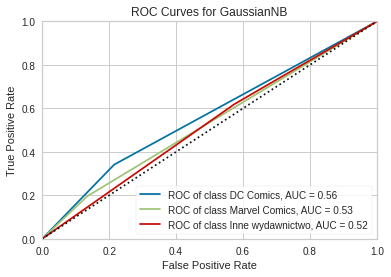

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9237df0810>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=GaussianNB(), force_model=True, macro=False, micro=False)

In [117]:
plot_ROC_curve(gnb_clf_all, X_train_dod_all, y_train_t, X_test_dod_all, y_test_t)

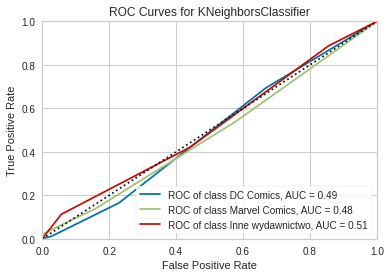

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9237b41610>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=KNeighborsClassifier(n_neighbors=3), force_model=True,
       macro=False, micro=False)

In [118]:
plot_ROC_curve(knn_clf_all, X_train_dod_all, y_train_t, X_test_dod_all, y_test_t)

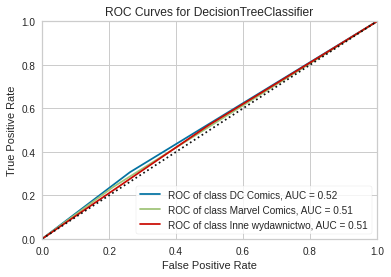

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9237b5a310>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=DecisionTreeClassifier(), force_model=True, macro=False,
       micro=False)

In [119]:
plot_ROC_curve(tree_clf_all, X_train_dod_all, y_train_t, X_test_dod_all, y_test_t)

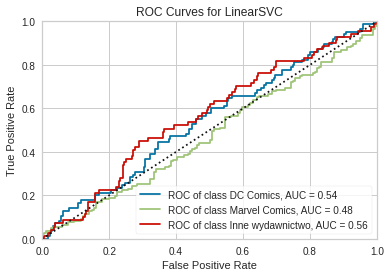

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9237b6bd90>,
       classes=['DC Comics', 'Marvel Comics', 'Inne wydawnictwo'],
       estimator=LinearSVC(C=0.01), force_model=True, macro=False, micro=False)

In [120]:
plot_ROC_curve(svm_clf_all, X_train_dod_all, y_train_t, X_test_dod_all, y_test_t)

## 10. Wnioski

Zaskakująco, patrząc na wyniki modeli dla całego zbioru danych, wyniki modeli są znacznie gorsze niż dla modeli, które posiadały jedynie dwie zmienne. Żaden z modeli nie przekroczył 0.5 dla trafności dla danych testowych. Krzywe ROC układają się na przekątnej. Mocno uogulniając modele dla całych danych poradziły sobie bardzo słabo, ale poradziły sobie bardzo słabo dla wszystkich kategorii. Nie ma kategorii, która się mocno wybija jako taka, którą łatwo przypisać (taką sytuację mieliśmy w #1. dla dwóch zmiennych, gdzie Marvel i DC mocno ciągnęły trafność w górę). A więc można powiedzieć, że modele nie faworyzują żadnej z grup.

Można wysnuć taki wniosek, że być może sytuacja ta związana jest z tym, że wielu superbohaterów ma podobne cechy, są silne, potrafią latać itp, i jest to niezależne od wydawnictwa. Najbardziej postacie te i wydawnictwa rozdzielają historie, ale gdy dodamy im punkty za inne umiejętności (mimo standaryzacji zmiennych numerycznych) granice te zaczynają się zacierać.